# Mie Polarization Rendering

This notebook demonstrates polarization rendering of a pure Mie scattering atmosphere. 

---

Related tutorials: 
 - Make Mie Table Polarized.ipynb - create mie tables.
 - Rayleigh Polarization Rendering.ipynb - rendering of a pure Rayleigh atmosphere.
 - Stcu Polarization Rendering.ipynb - rendering of a stcu cloud withing a Rayleigh atmosphere.

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import shdom

In [2]:
"""
Generate a uniform infinite layer cloud with properties matching case A5 
Liquid Water Cloud from IPRT comparison project: https://arxiv.org/pdf/1901.01813.pdf.

Note: 
This cell requieres a Mie table at path: '../mie_tables/Water_800nm_pol.scat'.
For more information on how to generate Mie tables see: Make Mie Table Polarized.ipynb 
"""
class Args:
    nx=10
    ny=10
    nz=10
    extinction=5.0
    reff=10.0
    albedo=1.0
    domain_size=1.0
    mie_table_path='../mie_tables/Water_800nm_pol.scat'
    
args = Args()
generator =  shdom.Generate.HomogeneousPolarized(args)
atmosphere = shdom.Medium()
atmosphere.set_optical_properties(generator.extinction, generator.albedo, generator.phase)

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.


In [3]:
"""
Define the numerical and scene parameters and solve polarized RTE.
Solve the Polarized Radiative Transfer for the domain 
using SHDOM: SOLVE_RTE procedure (src/polarized/shdomsub1.f)
"""
numerical_params = shdom.NumericalParameters()
source = shdom.SolarSource(azimuth=180, zenith=130)
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=source,
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
    surface=shdom.LambertianSurface(albedo=0.0)
) 
rte_solver = shdom.RteSolverPolarized(num_stokes=4, 
                                      scene_params=scene_params, 
                                      numerical_params=numerical_params)
rte_solver.init_medium(atmosphere)
rte_solver.solve(maxiter=100)

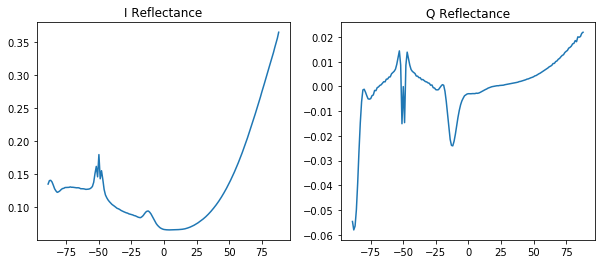

In [4]:
"""
Measure the reflected stokes vector along the solar principle plane.
Plot the reflectance I and Q components (Fig.3 of https://arxiv.org/pdf/1901.01813.pdf)
"""
camera = shdom.Camera(sensor=shdom.StokesSensor())
projection = shdom.PrincipalPlaneProjection(source=source, x=0.5, y=0.5, z=1.0)
camera.set_projection(projection)

stokes = camera.render(rte_solver)

%matplotlib inline
f, axes = plt.subplots(1, 2, figsize=(10, 4));
axes[0].plot(projection.angles, stokes[0,:]);
axes[0].set_title('I Reflectance');
axes[1].plot(projection.angles, stokes[1,:]);
axes[1].set_title('Q Reflectance');

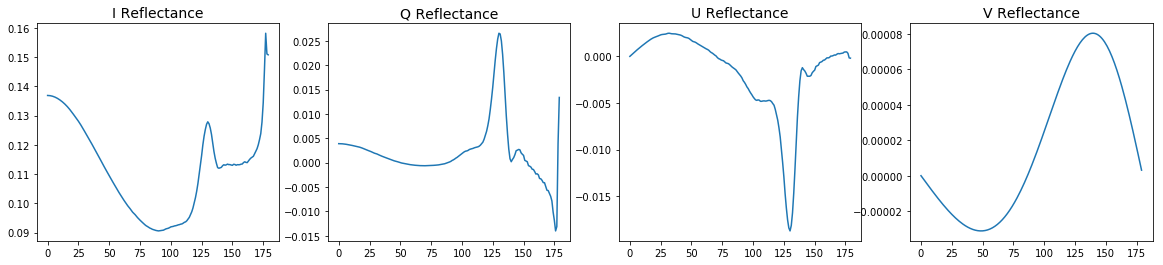

In [9]:
"""
Measure the reflected stokes vector along the solar almucantar plane.
Plot the reflectance I, Q, U, V components (Fig.4 of https://arxiv.org/pdf/1901.01813.pdf)

Note: 
The azimuth of the plots has a 180deg difference
"""
projection = shdom.AlmucantarProjection(source=source, x=0.5, y=0.5, z=1.0, resolution=1.0)
camera.set_projection(projection) 
stokes = camera.render(rte_solver)

%matplotlib inline
f, axes = plt.subplots(1, 4, figsize=(20, 4));
axes[0].plot(projection.azimuth-180, stokes[0,:])
axes[0].set_title('I Reflectance', fontsize=14);
axes[1].plot(projection.azimuth-180, stokes[1,:])
axes[1].set_title('Q Reflectance', fontsize=14);
axes[2].plot(projection.azimuth-180, stokes[2,:])
axes[2].set_title('U Reflectance', fontsize=14);
axes[3].plot(projection.azimuth-180, stokes[3,:])
axes[3].set_title('V Reflectance', fontsize=14);